In [1]:
# !pip install transformer_lens

In [22]:
import copy
from tqdm.notebook import tqdm
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
import einops

### config

In [6]:
p = 113
frac_train = 0.3

# Optimizer config
lr = 1e-3
wd = 1. 
betas = (0.9, 0.98)

num_epochs = 25000
checkpoint_every = 100

DATA_SEED = 598

### Define Task

- Define modular addition
    - $(a+b)\%p$
- Define the dataset & labels

In [7]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
equals_vector = einops.repeat(torch.tensor(113), " -> (i j)", i=p, j=p)

In [8]:
a_vector, b_vector

(tensor([  0,   0,   0,  ..., 112, 112, 112]),
 tensor([  0,   1,   2,  ..., 110, 111, 112]))

In [9]:
a_vector.shape, b_vector.shape, equals_vector.shape

(torch.Size([12769]), torch.Size([12769]), torch.Size([12769]))

In [10]:
dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).to(device)
print(dataset[:5])
print(dataset.shape)

tensor([[  0,   0, 113],
        [  0,   1, 113],
        [  0,   2, 113],
        [  0,   3, 113],
        [  0,   4, 113]], device='cuda:0')
torch.Size([12769, 3])


In [11]:
labels = (dataset[:, 0] + dataset[:, 1]) % p
print(labels.shape)
print(labels[:5])

torch.Size([12769])
tensor([0, 1, 2, 3, 4], device='cuda:0')


In [12]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p*p)
cutoff = int(p * p * frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data[:5])
print(train_labels[:5])
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[ 21,  31, 113],
        [ 30,  98, 113],
        [ 47,  10, 113],
        [ 86,  21, 113],
        [ 99,  83, 113]], device='cuda:0')
tensor([ 52,  15,  57, 107,  69], device='cuda:0')
torch.Size([3830, 3])
tensor([[ 43,  40, 113],
        [ 31,  42, 113],
        [ 39,  63, 113],
        [ 35,  61, 113],
        [112, 102, 113]], device='cuda:0')
tensor([ 83,  73, 102,  96, 101], device='cuda:0')
torch.Size([8939, 3])


### model

https://transformerlensorg.github.io/TransformerLens/generated/code/transformer_lens.HookedTransformerConfig.html
- `n_ctx`: The maximum sequence length.
-  n_heads = d_model // d_head

In [13]:
cfg = HookedTransformerConfig(
    n_layers=1,
    n_ctx=3,
    d_vocab=p+1,
    d_vocab_out=p,
    d_model=128,
    n_heads=4,
    d_head=32,
    d_mlp=512,
    act_fn="relu",
    normalization_type=None,
    init_weights=True,
    device=device,
    seed=999,
)

In [14]:
model = HookedTransformer(cfg)

In [15]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [16]:
for name, param in model.named_parameters():
    if "b_" in name:
        print(name)
        param.requires_grad = False

blocks.0.attn.b_Q
blocks.0.attn.b_O
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.mlp.b_in
blocks.0.mlp.b_out
unembed.b_U


### Optimizer + Loss

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [18]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
    
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)

tensor(4.7359, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(4.7330, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)


In [19]:
np.log(p)

4.727387818712341

### model train

In [20]:
model = HookedTransformer(cfg)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

for name, param in model.named_parameters():
    if "b_" in name:
        print(name)
        param.requires_grad = False

blocks.0.attn.b_Q
blocks.0.attn.b_O
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.mlp.b_in
blocks.0.mlp.b_out
unembed.b_U


In [21]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []

for epoch in tqdm(range(num_epochs)):
    train_logits = model(train_data)
    train_loss = loss_fn(train_logits, train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())

    optimizer.step()
    optimizer.zero_grad()

    with torch.inference_mode():
        test_logits = model(test_data)
        test_loss = loss_fn(test_logits, test_labels)
        test_losses.append(test_loss.item())
    
    if ((epoch+1) % checkpoint_every)==0:
        checkpoint_epochs.append(epoch)
        model_checkpoints.append(copy.deepcopy(model.state_dict()))
        if ((epoch+1) % 1000)==0:
            print(f"Epoch {epoch} Train Loss {train_loss.item():.4f} Test Loss {test_loss.item():.4f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

Epoch 999 Train Loss 0.0000 Test Loss 29.0522
Epoch 1999 Train Loss 0.0000 Test Loss 29.5949
Epoch 2999 Train Loss 0.0000 Test Loss 26.8188
Epoch 3999 Train Loss 0.0000 Test Loss 24.2656
Epoch 4999 Train Loss 0.0000 Test Loss 21.2289
Epoch 5999 Train Loss 0.0000 Test Loss 17.0924
Epoch 6999 Train Loss 0.0000 Test Loss 12.4340
Epoch 7999 Train Loss 0.0000 Test Loss 8.6068
Epoch 8999 Train Loss 0.0000 Test Loss 5.6697
Epoch 9999 Train Loss 0.0000 Test Loss 1.1866
Epoch 10999 Train Loss 0.0000 Test Loss 0.0458
Epoch 11999 Train Loss 0.0000 Test Loss 0.0000
Epoch 12999 Train Loss 0.0000 Test Loss 0.0000
Epoch 13999 Train Loss 0.0000 Test Loss 0.0000
Epoch 14999 Train Loss 0.0000 Test Loss 0.0000
Epoch 15999 Train Loss 0.0000 Test Loss 0.0000
Epoch 16999 Train Loss 0.0000 Test Loss 0.0000
Epoch 17999 Train Loss 0.0000 Test Loss 0.0000
Epoch 18999 Train Loss 0.0000 Test Loss 0.0000
Epoch 19999 Train Loss 0.0000 Test Loss 0.0000
Epoch 20999 Train Loss 0.0000 Test Loss 0.0000
Epoch 21999 Train

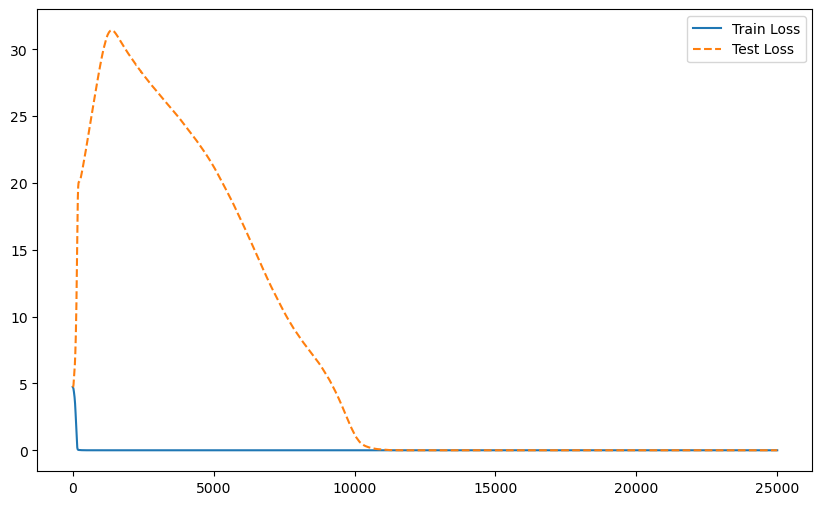

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss', linestyle='-')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss', linestyle='--')
plt.legend()